# course website
## [1)](https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/)
## [2)](https://dev.mrdbourke.com/tensorflow-deep-learning/05_transfer_learning_in_tensorflow_part_2_fine_tuning/)

# Libraries

In [ ]:
# !pip install -U -q tensorflow==2.9.0 # run it if you want to use tf.load_weights()
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [ ]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
import random
import zipfile
import os
import pathlib
import datetime

In [ ]:
!wget https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
import TfCommon

--2023-07-17 13:35:38--  https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13611 (13K) [text/plain]
Saving to: ‘TfCommon.py’

TfCommon.py         100%[===================>]  13.29K  --.-KB/s    in 0s      

2023-07-17 13:35:38 (41.3 MB/s) - ‘TfCommon.py’ saved [13611/13611]



# Future extraction

## Data

In [ ]:
!nvidia-smi

In [ ]:
# download
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

In [ ]:
tf.random.set_seed(42)

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

# normalize data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# set paths to data
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

# import data and batch it
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=IMG_SHAPE,
    class_mode='categorical',
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=BATCH_SIZE,
    target_size=IMG_SHAPE,
    class_mode='categorical',
    seed=42
)

TRAIN_BATCH_AMMOUNT = len(train_data)
VALID_BATCH_AMMOUNT = len(valid_data)

## TensorBoard callback - tracking experiments

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Models

In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [ ]:
def create_model_from_url(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax'if num_classes>2 else 'sigmoid', name='output_layer') # create our own output layer
  ])

  return model

In [ ]:
resnet_model = create_model_from_url(resnet_url, num_classes=train_data.num_classes)

In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
hist_m1 = resnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=TRAIN_BATCH_AMMOUNT,
    validation_data=valid_data,
    validation_steps=VALID_BATCH_AMMOUNT,
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="resnet50V2"
    )]
)

In [ ]:
TfCommon.plot_loss_curves([hist_m1])

In [ ]:
efficientnet_model = create_model_from_url(efficientnet_url, num_classes=train_data.num_classes)

In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
hist_m2 = efficientnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=TRAIN_BATCH_AMMOUNT,
    validation_data=valid_data,
    validation_steps=VALID_BATCH_AMMOUNT,
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="resnet50V2"
    )]
)

In [ ]:
TfCommon.plot_loss_curves([hist_m2])

## Comparing models

In [ ]:
TfCommon.plot_loss_curves([hist_m1, hist_m2])

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

In [ ]:
!tensorboard dev list

# Fine tuning

## Data 10%

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
TfCommon.unzip_data("10_food_classes_10_percent.zip")
TfCommon.walk_through_dir("10_food_classes_10_percent")

In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

In [ ]:
train_data_10_percent

In [ ]:
train_data_10_percent.class_names

## Base model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
# layer(x) means you pass layer to the left to x adding it to the model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[TfCommon.create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

In [ ]:
model_0.evaluate(test_data_10_percent)

In [ ]:
TfCommon.plot_loss_curves([history_10_percent])

In [ ]:
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

## Data 1%

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
TfCommon.unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# Walk through 1 percent data directory and list number of files
TfCommon.walk_through_dir("10_food_classes_1_percent")

In [ ]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

In [ ]:
# Make data augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")

In [ ]:
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[TfCommon.create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

In [ ]:
TfCommon.plot_loss_curves([history_1_percent])

## Model 2 - more data

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
initial_epochs = 5
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
# layer(x) means you pass layer to the left to x adding it to the model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

hist_m2 = model_2.fit(train_data_10_percent,
                                 epochs=initial_epochs,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[TfCommon.create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

In [ ]:
results_m2 = model_2.evaluate(test_data)
results_m2

In [ ]:
TfCommon.plot_loss_curves([hist_m2])

### ModelCheckpoint callback

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# Model_2 with Checkpoint callback
hist_m2_with_MCp = model_2.fit(train_data_10_percent,
                                 epochs=initial_epochs,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 callbacks=[TfCommon.create_tensorboard_callback("transfer_learning", "10_percent_feature_extract"), checkpoint_callback])

In [ ]:
model_2_raw_ev = model_2.evaluate(test_data_10_percent)
model_2.load_weights(checkpoint_path)
model_2_loaded_ev = model_2.evaluate(test_data_10_percent)

In [ ]:
# the values are diffrent but it's normal due to the way of saving data
print(model_2_raw_ev, model_2_loaded_ev)
np.isclose(model_2_raw_ev, model_2_loaded_ev)

## Model 3 - Fine tuning

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

In [ ]:
print(len(model_2.layers[2].trainable_variables))
print(len(base_model.trainable_variables))

In [ ]:
count_trainable_layers = [0, 0]
for layer_number, layer in enumerate(base_model.layers):
  count_trainable_layers[layer.trainable]+=1
print(f'There are {count_trainable_layers[0]} untrainable layers and {count_trainable_layers[1]} trainable layers in base model')

In [ ]:
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
TfCommon.count_trainable_layers(base_model)

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
hist_m3 = model_2.fit(
    train_data_10_percent,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    initial_epoch=hist_m2.epoch[-1], # start from previous last epoch
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[TfCommon.create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")] # name experiment appropriately
)

In [ ]:
model_3_ev = model_2.evaluate(test_data_10_percent)

## Data 100%

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
TfCommon.unzip_data('10_food_classes_all_data.zip')

train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [ ]:
TfCommon.walk_through_dir('10_food_classes_all_data')

In [ ]:
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

In [ ]:
model_2.evaluate(test_data)

In [ ]:
# load weights from checkpoint
checkpoint_dir = 'ten_percent_model_checkpoints_weights'
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)
print(latest_weights)

model_2.load_weights(latest_weights)
model_2.evaluate(test_data)

## Model 4

In [ ]:
count_trainable_layers = [0, 0]
for layer_number, layer in enumerate(base_model.layers):
  count_trainable_layers[layer.trainable]+=1
print(f'There are {count_trainable_layers[0]} untrainable layers and {count_trainable_layers[1]} trainable layers in base model')

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
hist_m4 = model_2.fit(
    train_data,
    epochs=fine_tune_epochs,
    initial_epoch=hist_m2.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[TfCommon.create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")]
)

## Summary of models

In [ ]:
TfCommon.plot_loss_curves([history_10_percent, history_1_percent, hist_m2, hist_m3, hist_m4])

In [ ]:
def compare_hystories(original_history, new_history, initial_epochs=5, verbose=1):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    if verbose:
      print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    if verbose:
      print(len(total_acc))
      print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
compare_hystories(original_history=hist_m2,
                 new_history=hist_m3,
                 initial_epochs=5)

In [ ]:
compare_hystories(original_history=hist_m2,
                 new_history=hist_m4,
                 initial_epochs=5)

# Scaling up

## 101 classes data - 10%

In [ ]:
!wget !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
TfCommon.unzip_data('101_food_classes_10_percent.zip')
TfCommon.walk_through_dir("101_food_classes_10_percent")

--2023-07-14 20:46:43--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2023-07-14 20:46:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  32.4MB/s    in 52s     

2023-07-14 20:47:35 (30.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

FINISHED --2023-07-14 20:47:35--
Total wall clock time: 52s
Downloaded: 1 files, 1.5G in 52s (30.0 MB/s)
There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 im

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
BATCH_SIZE=32
IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical", # what type are the labels?
    batch_size=BATCH_SIZE, # batch_size is 32 by default, this is generally a good number
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
train_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## model 5

In [ ]:
checkpoint_path = 'model_5_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
data_augmentation = Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
        layers.RandomZoom(0.2)
    ], name='data_augmentation'
)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model_5 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

hist_m5 = model_5.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 1034s 4s/step - loss: 3.3655 - accuracy: 0.2663 - val_loss: 2.3094 - val_accuracy: 0.5140
Epoch 2/5
237/237 [==============================] - 1014s 4s/step - loss: 2.2051 - accuracy: 0.4957 - val_loss: 1.9002 - val_accuracy: 0.5519
Epoch 3/5
237/237 [==============================] - 1006s 4s/step - loss: 1.8175 - accuracy: 0.5687 - val_loss: 1.7300 - val_accuracy: 0.5731
Epoch 4/5
237/237 [==============================] - 967s 4s/step - loss: 1.5937 - accuracy: 0.6190 - val_loss: 1.6831 - val_accuracy: 0.5686
Epoch 5/5
 84/237 [=========>....................] - ETA: 6:46 - loss: 1.4717 - accuracy: 0.6347

In [ ]:
model_5.evaluate(test_data)

In [ ]:
# Curves say that the model is overfitting
TfCommon.plot_loss_curves([hist_m5])

### Model 5 - save (run loading only)

In [ ]:
model_5.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/transfer_learning_model_5_base')

In [ ]:
model_5 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/transfer_learning_model_5_base')
res_5 = model_5.evaluate(test_data)

790/790 [==============================] - 94s 108ms/step - loss: 1.5845 - accuracy: 0.5832


## Model_5a - Fine-tuning

In [ ]:
model_5.trainable = True

# Freeze all layers except for the last 5
for layer in model_5.layers[:-5]:
  layer.trainable = False

In [ ]:
model_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)

In [ ]:
TfCommon.count_trainable_layers(model_5)

In [ ]:
initial_epochs = 5

# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

hist_m5a = model_5.fit(
    train_data,
    epochs=fine_tune_epochs,
    initial_epoch=hist_m5.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[TfCommon.create_tensorboard_callback("scaling up", "model_5a")]
)

In [ ]:
model_5.evaluate(test_data)

In [ ]:
TfCommon.compare_hystories(original_history=hist_m5,
                 new_history=hist_m5a,
                 initial_epochs=5)

### Model 5a - save (run loading only only)

In [ ]:
model_5.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/transfer_learning_model_5a_fineTuned')

In [ ]:
model_5a = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/transfer_learning_model_5a_fineTuned')
res_5a = model_5a.evaluate(test_data)

790/790 [==============================] - 75s 92ms/step - loss: 1.8755 - accuracy: 0.6027


## Model_5b - Evaluate the performence of pre-trained model

### Load Model

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
TfCommon.unzip_data(saved_model_path)

--2023-07-14 20:52:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  23.7MB/s    in 1.9s    

2023-07-14 20:52:25 (23.7 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
model_5b = tf.keras.models.load_model(saved_model_path.split(".")[0])

### Evaluate performence

In [ ]:
res_5b = model_5b.evaluate(test_data)
res_5b

790/790 [==============================] - 86s 107ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [ ]:
pred_probs = model_5b.predict(test_data, verbose=1)

790/790 [==============================] - 72s 90ms/step


In [ ]:
print(
    len(test_data) * BATCH_SIZE,
    len(pred_probs)
)

25280 25250


In [ ]:
print(
    pred_probs.shape, '\n',
    pred_probs[0], '\n',
    len(pred_probs[0]), '\n',
    sum(pred_probs[0]), '\n',
    np.argmax(pred_probs[0]), test_data.class_names[np.argmax(pred_probs[0])], ':', np.round(max(pred_probs[0]), 2), '%', '\n'
)

(25250, 101) 
 [5.95422126e-02 3.57421368e-06 4.13770415e-02 1.06606324e-09
 8.16142531e-09 8.66396288e-09 8.09274070e-07 8.56529539e-07
 1.98591606e-05 8.09774235e-07 3.17277338e-09 9.86737973e-07
 2.85322894e-04 7.80490172e-10 7.42304197e-04 3.89164816e-05
 6.47405386e-06 2.49774143e-06 3.78911900e-05 2.06782616e-07
 1.55384460e-05 8.15073861e-07 2.62306344e-06 2.00106967e-07
 8.38279050e-07 5.42160706e-06 3.73909870e-06 1.31505775e-08
 2.77615804e-03 2.80519871e-05 6.85621337e-10 2.55748728e-05
 1.66889717e-04 7.64069696e-10 4.04530176e-04 1.31506805e-08
 1.79573726e-06 1.44482397e-06 2.30628941e-02 8.24670678e-07
 8.53659003e-07 1.71386728e-06 7.05256207e-06 1.84021616e-08
 2.85534497e-07 7.94839616e-06 2.06815457e-06 1.85251992e-07
 3.36197594e-08 3.15226032e-04 1.04109295e-05 8.54483289e-07
 8.47418368e-01 1.05554509e-05 4.40948213e-07 3.74041701e-05
 3.53062496e-05 3.24890570e-05 6.73149116e-05 1.28526620e-08
 2.62198513e-10 1.03181155e-05 8.57439300e-05 1.05699314e-06
 2.129340

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
print(f"Close? {np.isclose(res_5b[1], sklearn_accuracy)} | Difference: {res_5b[1] - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict['0']

{'precision': 0.29310344827586204,
 'recall': 0.204,
 'f1-score': 0.24056603773584903,
 'support': 250}

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
class_f1_scores[test_data.class_names[0]]

0.24056603773584903

In [ ]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008


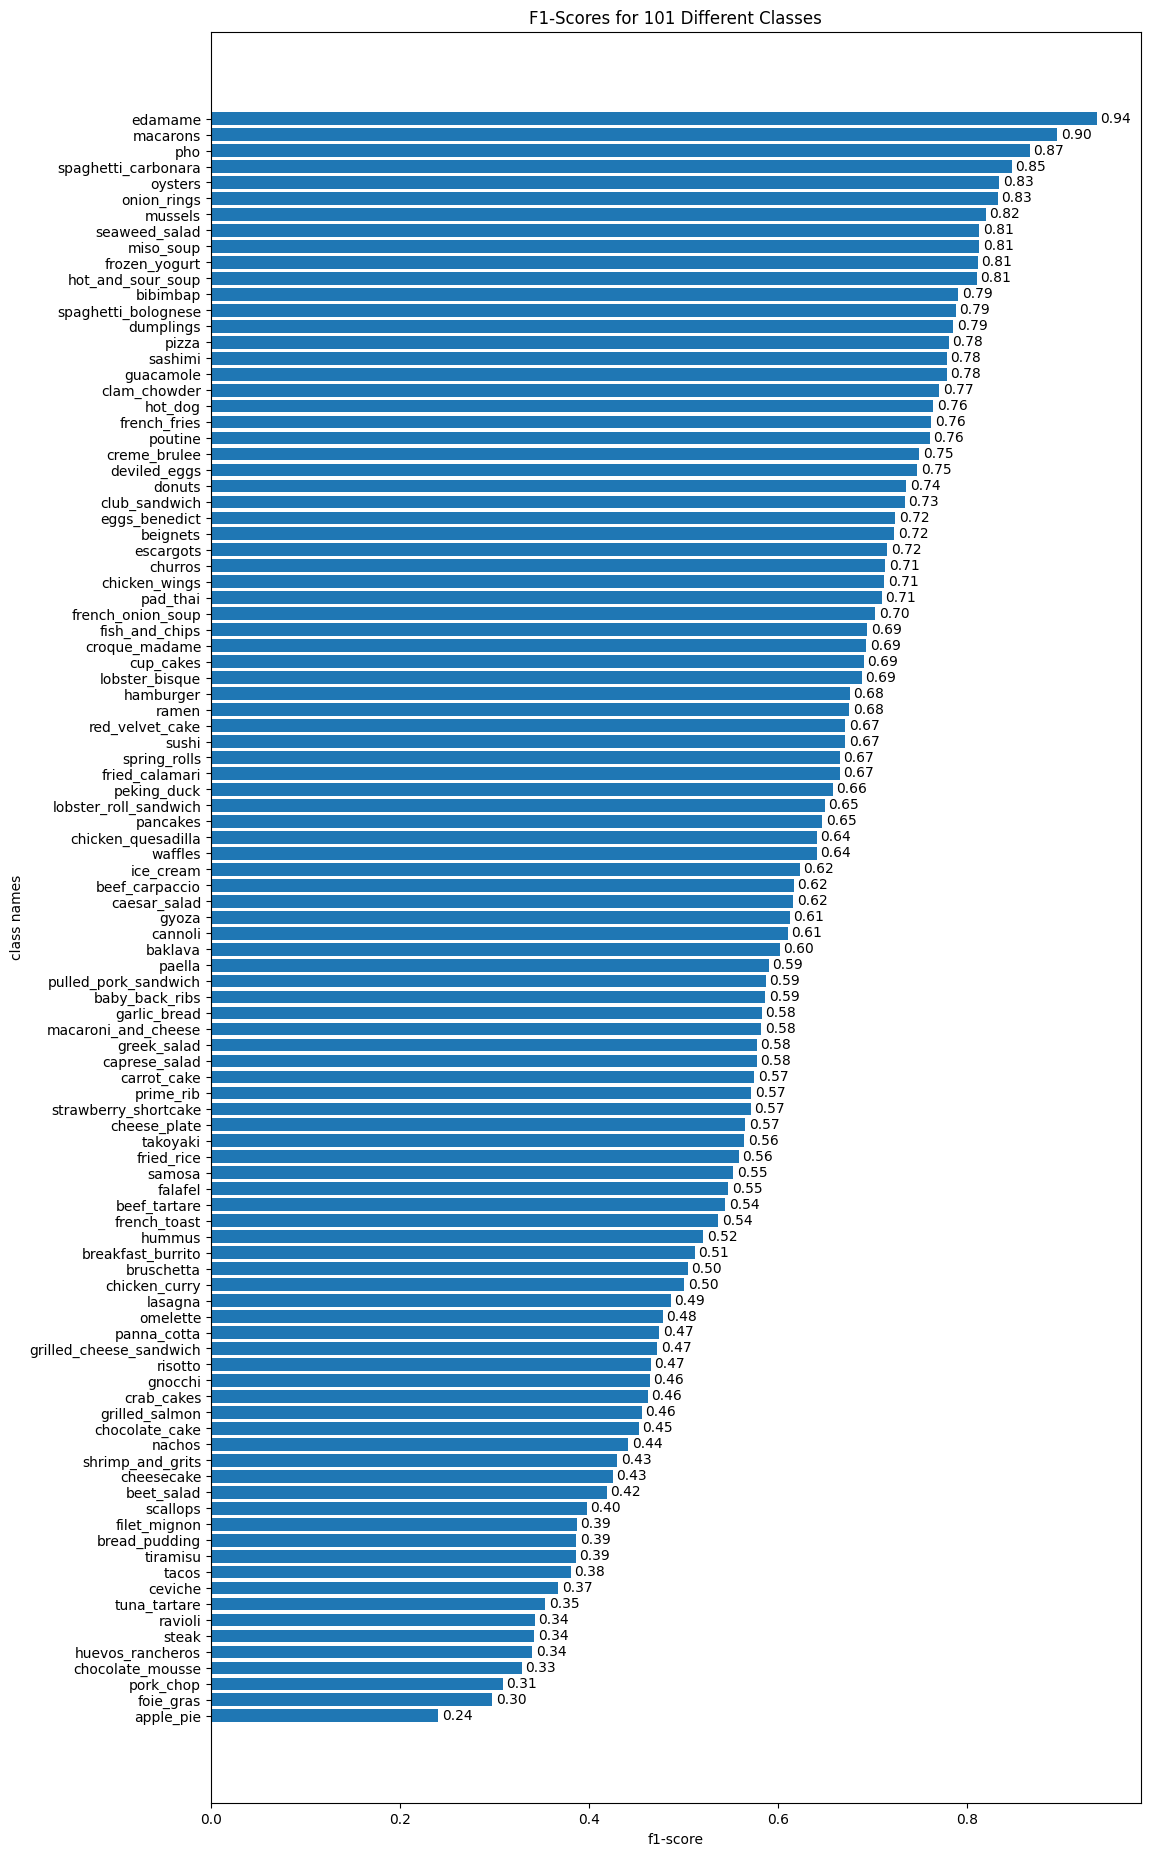

In [ ]:
fig, ax = plt.subplots(figsize=(12, 23))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)), f1_scores['class_name'].values)
ax.set_xlabel('f1-score')
ax.set_ylabel('class names')
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis()

def autolabel(rects): # From: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(width+0.02, rect.get_y() + rect.get_height(),
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on test images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
plt.figure(figsize=(100, 100))

for i in range(20):
  # Choose a random image from a random class
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_5b.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = test_data.class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(10, 10, 1+i)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontsize=10)
  plt.axis(False);

Output hidden; open in https://colab.research.google.com to view.

## Finding the most wrong predictions

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [test_data.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data.class_names[i] for i in pred_classes]})
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847418,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367902,apple_pie,prime_rib


In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847418,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367902,apple_pie,prime_rib,False


In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999981,samosa,spring_rolls,False
24540,b'101_food_classes_10_percent/test/tiramisu/16...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'101_food_classes_10_percent/test/bruschetta/...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'101_food_classes_10_percent/test/chocolate_m...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.999931,paella,mussels,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.999904,sushi,sashimi,False


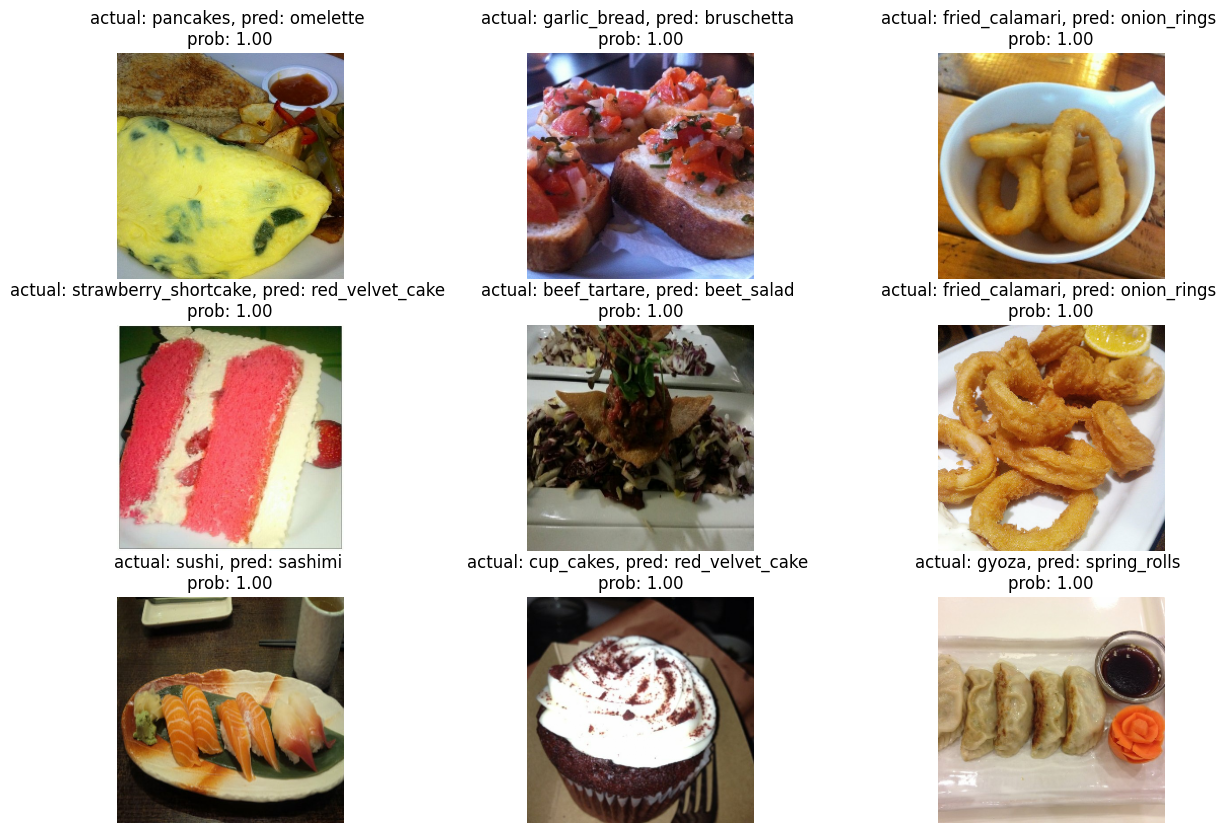

In [ ]:
images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

## Test models on custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

TfCommon.unzip_data("custom_food_images.zip")

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Big Model

## Data

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f829e9cf-2f6d-e92b-30cd-aed145c5be64)


In [ ]:
datasets_list = tfds.list_builders()
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [ ]:
(train_data, test_data), ds_info = tfds.load(
    name=target_dataset,
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteEU61TG/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteEU61TG/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """
)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 74
  Class name (str form): peking_duck
  


In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

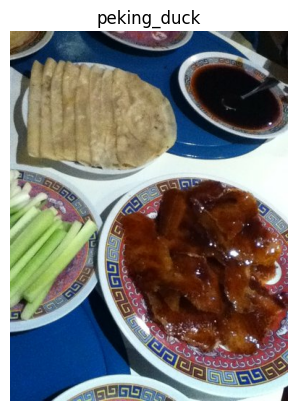

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]

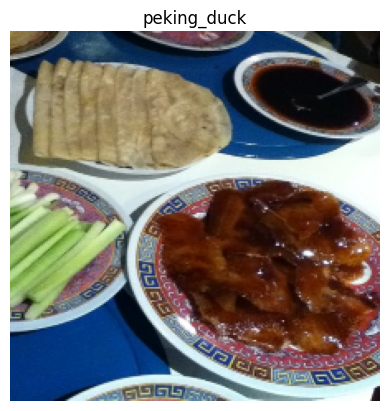

In [ ]:
plt.imshow(preprocessed_img/255.) # divide by 255 (for matplotlib capatibility)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create Callbacks

In [ ]:
from TfCommon import create_tensorboard_callback
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_acc',
    save_best_only=True,
    save_weigths_only=True,
    verbose=0
)

## model_6 - 101 classes, full data, mixed precision

In [ ]:
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                              

In [ ]:
for layer in model_6.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
hist_m6 = model_6.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        TfCommon.create_tensorboard_callback("Big model", "model_6"),
        model_checkpoint
    ]
)

Saving TensorBoard log files to: Big model/model_6/20230717-151038
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7161 - accuracy: 0.5822

2368/2368 [==============================] - 275s 107ms/step - loss: 1.7161 - accuracy: 0.5822 - val_loss: 1.1295 - val_accuracy: 0.6907
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1982 - accuracy: 0.6895

2368/2368 [==============================] - 262s 109ms/step - loss: 1.1981 - accuracy: 0.6895 - val_loss: 1.0364 - val_accuracy: 0.7156
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.7238

2368/2368 [==============================] - 228s 95ms/step - loss: 1.0528 - accuracy: 0.7238 - val_loss: 0.9988 - val_accuracy: 0.7182


In [ ]:
res_m6 = model_6.evaluate(test_data)
res_m6

### Model 6 - save (run loading only only)

In [ ]:
model_6.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/transfer_learning_model_6a_fineTuned')

In [ ]:
model_6 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/transfer_learning_model_6a_fineTuned')
res_6 = model_6.evaluate(test_data)

## model_6a - Fine tuning

In [ ]:
model_6.trainable = True

# Freeze all layers except for the last 5
for layer in model_6.layers[:-10]:
  layer.trainable = False

In [ ]:
model_6.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=["accuracy"]
)

In [ ]:
initial_epochs = 3
fine_tune_epochs = initial_epochs + 3

hist_m6a = model_6.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    initial_epoch=hist_m6.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[TfCommon.create_tensorboard_callback("Big model", "model_6a")]
)

Saving TensorBoard log files to: Big model/model_6a/20230717-152324
Epoch 3/6
2368/2368 [==============================] - 441s 158ms/step - loss: 1.5573 - accuracy: 0.5986 - val_loss: 1.2039 - val_accuracy: 0.6713
Epoch 4/6
2368/2368 [==============================] - 374s 156ms/step - loss: 1.1951 - accuracy: 0.6848 - val_loss: 1.0647 - val_accuracy: 0.7140
Epoch 5/6
2368/2368 [==============================] - 371s 156ms/step - loss: 1.0239 - accuracy: 0.7212 - val_loss: 0.9819 - val_accuracy: 0.7360
Epoch 6/6
2368/2368 [==============================] - 368s 155ms/step - loss: 0.8791 - accuracy: 0.7578 - val_loss: 0.9379 - val_accuracy: 0.7495


3
7
[0.5822046399116516, 0.6895049214363098, 0.7238152027130127, 0.5986402630805969, 0.6847788691520691, 0.7212145328521729, 0.7577821612358093]


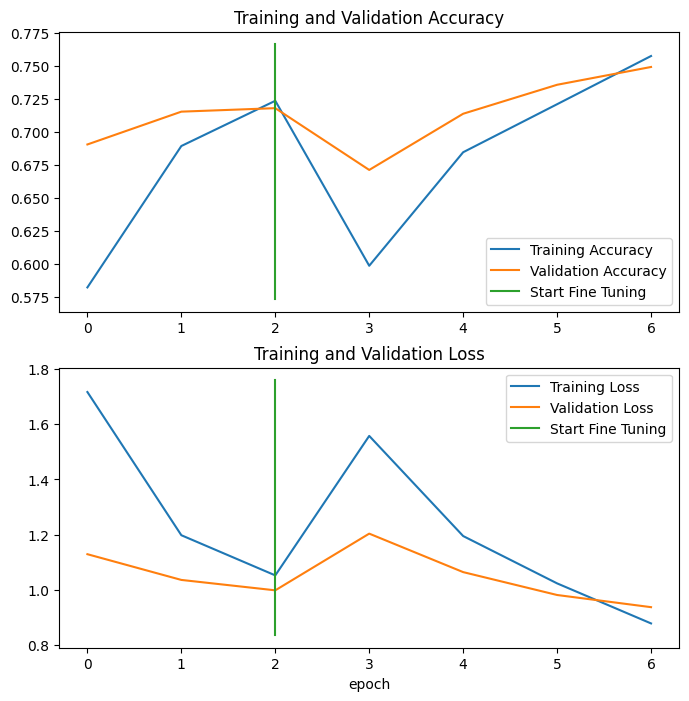

In [ ]:
TfCommon.compare_hystories(original_history=hist_m6,
                 new_history=hist_m6a,
                 initial_epochs=3)